# Expectaiton Maximization

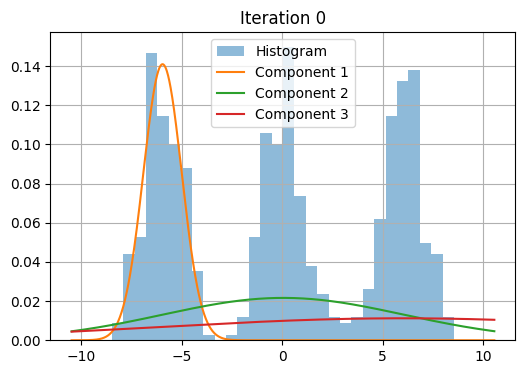

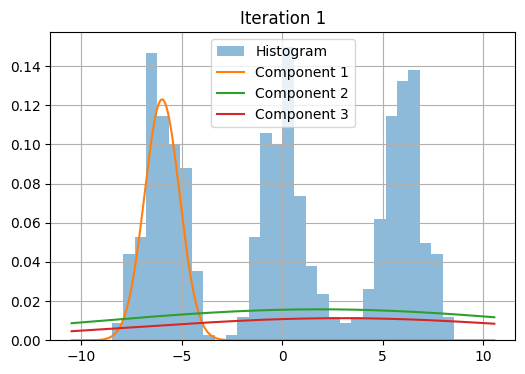

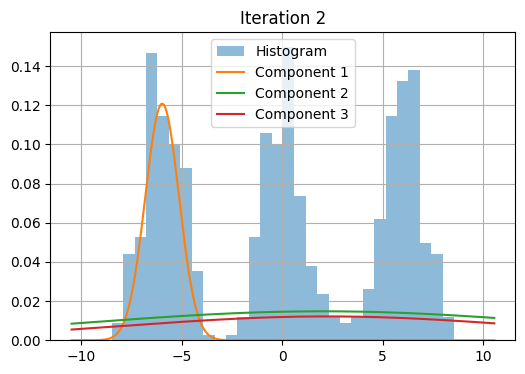

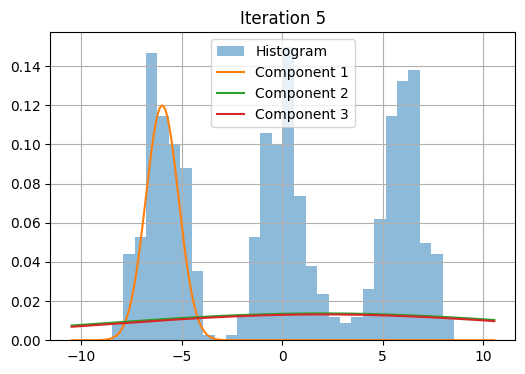

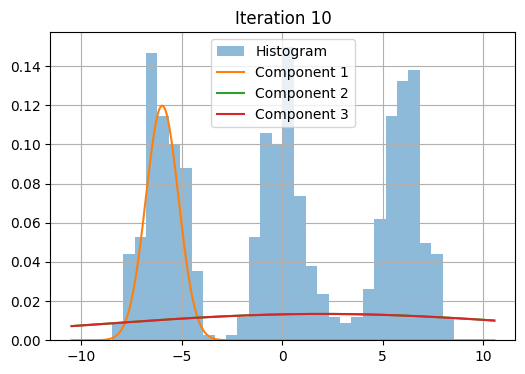

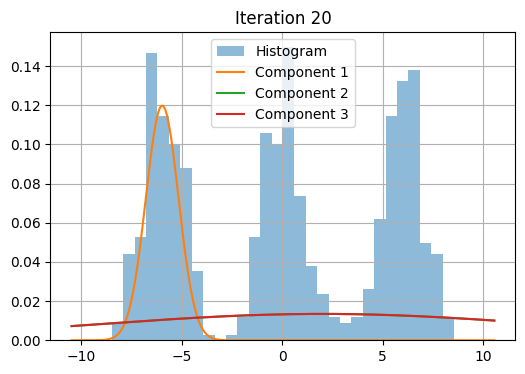

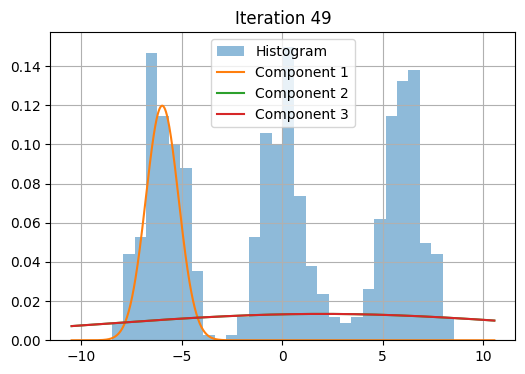

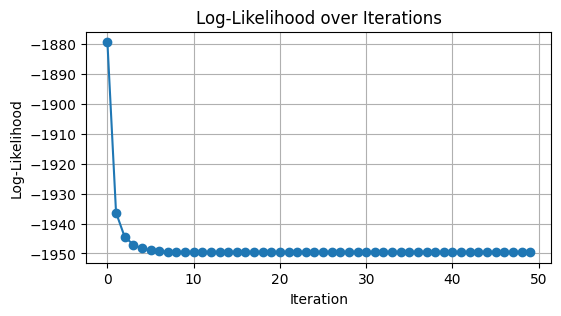

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set seed for reproducibility
np.random.seed(42)

# --- Generate 1D data from 3 Gaussians ---
N = 600
true_means = np.array([-6, 0, 6])
true_stds = np.array([1.0, 1.0, 1.0])
true_pis = np.array([1/3, 1/3, 1/3])

components = np.random.choice(3, size=N, p=true_pis)
data = np.random.normal(loc=true_means[components], scale=true_stds[components])

# Number of components
K = 3

# --- Initialize mu, sigma, pi using sorted thirds (percentile-based) ---
sorted_data = np.sort(data)
third = N // 3
clusters = [sorted_data[i*third:(i+1)*third] for i in range(K)]
mu = np.array([np.mean(c) for c in clusters])
sigma = np.array([np.std(c) + 1e-3 for c in clusters])
pi = np.array([len(c) / len(data) for c in clusters])

# --- Helper: Gaussian PDF ---
def gaussian_pdf(x, mean, std):
    return norm.pdf(x, loc=float(np.ravel(mean)[0]), scale=float(np.ravel(std)[0]))

# --- Optional: hard-assignment bootstrapping for better separation ---
for _ in range(3):
    distances = np.abs(data[:, np.newaxis] - mu[np.newaxis, :])
    hard_assignments = np.argmin(distances, axis=1)
    for k in range(K):
        assigned_data = data[hard_assignments == k]
        if len(assigned_data) > 0:
            mu[k] = np.mean(assigned_data)
            sigma[k] = np.std(assigned_data) + 1e-3
            pi[k] = len(assigned_data) / len(data)

# --- Run soft EM algorithm ---
log_likelihoods = []
num_iters = 50

for iteration in range(num_iters):
    # E-step: compute responsibilities γ(z_nk)
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * gaussian_pdf(data, mu[k], sigma[k])
    gamma /= gamma.sum(axis=1, keepdims=True)

    # M-step: update parameters
    N_k = gamma.sum(axis=0)
    mu = (gamma.T @ data) / N_k
    sigma = np.sqrt((gamma.T @ (data[:, None] - mu)**2) / N_k)
    pi = N_k / N

    # Log-likelihood
    ll = np.sum(np.log(np.sum([
        pi[k] * gaussian_pdf(data, mu[k], sigma[k]) for k in range(K)
    ], axis=0)))
    log_likelihoods.append(ll)

    # --- Optional debug plot every 10 iterations ---
    if iteration in [0, 1, 2, 5, 10, 20, 49]:
        plt.figure(figsize=(6, 4))
        plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram')
        x_vals = np.linspace(data.min() - 2, data.max() + 2, 1000)
        for k in range(K):=
            plt.plot(
                x_vals,
                pi[k] * gaussian_pdf(x_vals, mu[k], sigma[k]),
                label=f'Component {k+1}'
            )
        plt.title(f'Iteration {iteration}')
        plt.legend()
        plt.grid(True)
        plt.show()

# --- Final plot of log-likelihood ---
plt.figure(figsize=(6, 3))
plt.plot(log_likelihoods, marker='o')
plt.title('Log-Likelihood over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()


# Plot 1D

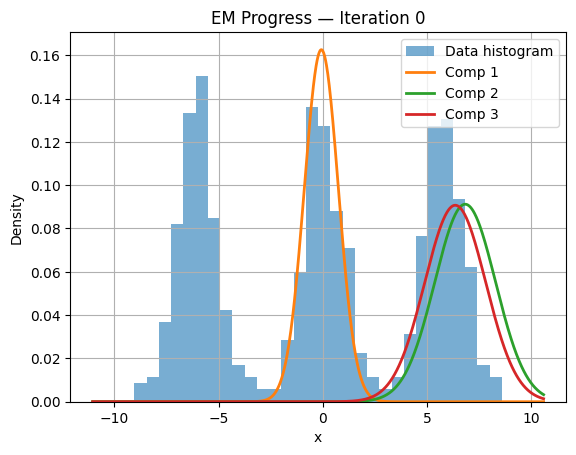

In [15]:
import matplotlib.animation as animation

# Plotting function to visualize mixture model over histogram
def plot_em_progress(data, mu_hist, sigma_hist, pi_hist, steps, title="EM Progress"):
    x_vals = np.linspace(data.min() - 2, data.max() + 2, 1000)
    fig, ax = plt.subplots()

    def update(frame):
        ax.clear()
        ax.hist(data, bins=30, density=True, alpha=0.6, label='Data histogram')
        for k in range(K):
            y_vals = pi_hist[frame][k] * gaussian_pdf(x_vals, mu_hist[frame][k], sigma_hist[frame][k])
            ax.plot(x_vals, y_vals, label=f'Comp {k+1}', lw=2)
        ax.set_title(f"{title} — Iteration {steps[frame]}")
        ax.set_xlabel("x")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True)

    return animation.FuncAnimation(fig, update, frames=len(steps), repeat=False)

# Modified EM to save intermediate steps
def em_with_tracking(data, K, mu, sigma, pi, max_iter=100, tol=1e-4, track_iters=[0, 1, 5, 10, 20]):
    N = len(data)
    log_likelihoods = []

    mu_hist = []
    sigma_hist = []
    pi_hist = []
    iter_recorded = []

    for iteration in range(max_iter):
        # E-step
        gamma = np.zeros((N, K))
        for k in range(K):
            gamma[:, k] = pi[k] * gaussian_pdf(data, mu[k], sigma[k])
        gamma /= gamma.sum(axis=1, keepdims=True)

        # M-step
        N_k = gamma.sum(axis=0)
        mu_new = (gamma.T @ data) / N_k
        sigma_new = np.sqrt((gamma.T @ (data[:, np.newaxis] - mu_new)**2) / N_k)
        pi_new = N_k / N

        # Log-likelihood
        log_likelihood = np.sum(np.log(np.sum([
            pi[k] * gaussian_pdf(data, mu[k], sigma[k]) for k in range(K)
        ], axis=0)))
        log_likelihoods.append(log_likelihood)

        if iteration in track_iters:
            mu_hist.append(mu.copy())
            sigma_hist.append(sigma.copy())
            pi_hist.append(pi.copy())
            iter_recorded.append(iteration)

        # Convergence
        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

        mu, sigma, pi = mu_new, sigma_new, pi_new

    # Always store the final iteration
    mu_hist.append(mu.copy())
    sigma_hist.append(sigma.copy())
    pi_hist.append(pi.copy())
    iter_recorded.append(iteration)

    return mu, sigma, pi, gamma, log_likelihoods, mu_hist, sigma_hist, pi_hist, iter_recorded

# Run EM with tracking
mu_init = np.random.choice(data, K)
sigma_init = np.random.rand(K) + 0.5
pi_init = np.ones(K) / K

mu_final, sigma_final, pi_final, _, log_likelihoods, mu_hist, sigma_hist, pi_hist, iter_recorded = em_with_tracking(
    data, K, mu_init, sigma_init, pi_init, track_iters=[0, 1, 5, 10, 20]
)

# Create and persist animation
em_anim = plot_em_progress(data, mu_hist, sigma_hist, pi_hist, iter_recorded)

# Prevent garbage collection by assigning to a global variable
from IPython.display import HTML
HTML(em_anim.to_jshtml())



# 2D EM(image 9.8 replication)

In [29]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

# Load faithful dataset (from seaborn's "geyser")
df = sns.load_dataset('geyser').dropna()
X = df[['waiting', 'duration']].values
X = StandardScaler().fit_transform(X)

# EM Parameters
K = 2
N, D = X.shape

# Initialize
np.random.seed(42)
mu = X[np.random.choice(N, K, replace=False)]
sigma = np.array([np.eye(D) for _ in range(K)])
pi = np.ones(K) / K

def multivariate_gaussian(X, mu, sigma):
    return np.array([multivariate_normal.pdf(X[i], mean=mu, cov=sigma) for i in range(len(X))])

def e_step(X, mu, sigma, pi):
    N, K = X.shape[0], len(pi)
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * multivariate_gaussian(X, mu[k], sigma[k])
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def m_step(X, gamma):
    N_k = gamma.sum(axis=0)
    mu_new = (gamma.T @ X) / N_k[:, None]
    sigma_new = np.zeros((K, D, D))
    for k in range(K):
        X_centered = X - mu_new[k]
        sigma_new[k] = (gamma[:, k][:, None] * X_centered).T @ X_centered / N_k[k]
    pi_new = N_k / X.shape[0]
    return mu_new, sigma_new, pi_new

# Run EM and store snapshots
snapshots = {}

for iteration in range(21):
    gamma = e_step(X, mu, sigma, pi)
    mu, sigma, pi = m_step(X, gamma)

    if iteration in [0, 1, 2, 5, 20]:
        snapshots[iteration] = {
            'mu': mu.copy(),
            'sigma': sigma.copy(),
            'pi': pi.copy(),
            'gamma': gamma.copy()
        }

# Plotting helpers
def draw_ellipse(ax, mean, cov, color):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * np.sqrt(vals)
    for scale in [1]:
        ell = Ellipse(xy=mean, width=width*scale, height=height*scale, angle=angle,
                      edgecolor=color, lw=2, facecolor='none')
        ax.add_patch(ell)

# Colors
colors = ['red', 'blue', 'purple']

# Plotting 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
titles = ['Init', 'Color Assignments', 'L = 1', 'L = 2', 'L = 5', 'L = 20']

for idx, ax in enumerate(axes.flat):
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[idx], fontsize=14)

    if idx == 0:
        # First plot: all green, diagonal, 2 empty circles
        ax.scatter(X[:, 0], X[:, 1], c='green', alpha=0.6)
        ax.plot([-2, 2], [-2, 2], linestyle='--', color='gray')
        ax.scatter(-1, 1, s=200, edgecolors='blue', facecolors='none', lw=2)
        ax.scatter(1, -1, s=200, edgecolors='red', facecolors='none', lw=2)

    elif idx == 1:
        # Color assignments (hard clustering based on gamma)
        snap = snapshots[0]
        cluster_ids = np.argmax(snap['gamma'], axis=1)
        colors_mixed = [colors[i] for i in cluster_ids]
        ax.scatter(X[:, 0], X[:, 1], c=colors_mixed, alpha=0.6)
        for k in range(K):
            draw_ellipse(ax, snap['mu'][k], snap['sigma'][k], ['red', 'blue'][k])

    else:
        L = [1, 2, 5, 20][idx - 2]
        snap = snapshots[L]
        cluster_ids = np.argmax(snap['gamma'], axis=1)
        confidences = snap['gamma'].max(axis=1)

        # Hard color or purple if uncertain
        point_colors = []
        for i in range(len(X)):
            if confidences[i] < 0.9:
                point_colors.append('purple')
            else:
                point_colors.append(['red', 'blue'][cluster_ids[i]])

        ax.scatter(X[:, 0], X[:, 1], c=point_colors, alpha=0.6)
        ax.text(-1.8, 1.8, f"L = {L}", fontsize=12, weight='bold')

        for k in range(K):
            draw_ellipse(ax, snap['mu'][k], snap['sigma'][k], ['red', 'blue'][k])

plt.suptitle("EM Algorithm on 2D Faithful Dataset — Iterative Visualization", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


NameError: name 'multivariate_normal' is not defined